# Физическое моделирование уровня воды на гидрологическом посте 3036

In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat May 29 15:22:41 2021

@author: mike_ubuntu
"""

import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 15)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

import matplotlib.pylab as pylab

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 14),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         #'axes.weight': 'bold',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

import matplotlib.dates as mdates
import seaborn as sns

import scipy.stats as stats
import os
    

#import numpy as np
import scipy.optimize as optimize
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
#from sklearn.mixture import GaussianMixture

import scipy as sp

def dbscan_predict(dbscan_model, X_new, metric=sp.spatial.distance.cosine):
    '''
    Function taken from 
    https://stackoverflow.com/questions/27822752/scikit-learn-predicting-new-points-with-dbscan
    '''

    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break
    return y_new

#def spectral_clustring_predict(clustering_model, X_new, metric=sp.spatial.distance.cosine):
#    y_new = np.ones(shape=len(X_new), dtype=int)*-1 
#
#    # Iterate all input samples for a label
#    for j, x_new in enumerate(X_new):
#        # Find a core sample closer than EPS
#        for i, x_core in enumerate(dbscan_model.components_): 
#            if metric(x_new, x_core) < dbscan_model.eps:
#                # Assign label of x_core to x_new
#                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
#                break
#
#    return y_new    

def model_equation(params, variables):
    '''
    params : np.array
        parameters of the runoff model, params[0] - snow runoff coeff, params[1] - rain_runoff_coeff,
        params[2] - discharge recession coeff, params[3] - degree day factor,
        params[4] - downstream flow coeff;
        
    variables : tuple
        physical variables of the runoff model    
        variables[0] - degree days, variables[1] - fractional snow cover, variables[2] - watershed area,
        variables[3] - rainfall, variables[4] - discharge, variables[5] - upstream point data
        
    '''    
    k = 10000./86400.    
    return ((params[0] * params[3] * variables[0] * variables[1] + 
                         params[1] * variables[3]) * variables[2] * k * (1 - params[2]) + 
                         params[2] * variables[4] + 
                         params[4] * (variables[4] - variables[5]))


def opt_equation(params, *variables):
    '''
    params : np.array
        parameters of the runoff model, params[0] - snow runoff coeff, params[1] - rain_runoff_coeff,
        params[2] - discharge recession coeff, params[3] - degree day factor,
        params[4] - downstream flow coeff;
        
    variables : tuple
        physical variables of the runoff model    
        variables[0] - degree days, variables[1] - fractional snow cover, variables[2] - watershed area,
        variables[3] - rainfall, variables[4] - discharge, variables[5] - upstream point data
        
    '''
    k = 10000./86400.
    
    f_py = lambda t_idx: ((params[0] * params[3] * variables[0][t_idx-1] * variables[1][t_idx-1] + 
                         params[1] * variables[3][t_idx-1]) * variables[2] * k * (1 - params[2]) + 
                         params[2] * variables[4][t_idx-1] + 
                         params[4] * (variables[4][t_idx-1] - variables[5][t_idx-1]) - variables[4][t_idx])
    f_vect = np.vectorize(f_py)
    res = np.sum(np.abs(f_vect(np.arange(1, variables[4].size))))
    #print(res, res.shape)#, np.sum(res) ** 2, (np.sum(res) ** 2).shape)
    return res
    
class discharge_model(object):
    def __init__(self):
        self.params_list = ['snow_runoff', 'rain_runoff', 'discharge_recession',
                            'degree_day_factor', 'downstream flow']
        self.var_list = ['degree_days', 'frac_snow_cover', 'area', 'rainfall', 'point_discharge', 'upsteam_discharge']
    
    def get_clusters(self, data, eps = 0.5, base_clusters = 10):
        self.data_shape = data.shape
        self.clustering_method = 'DBSCAN'
        self.pca = PCA(n_components=2)
        self.pca.fit(data)
        #print(self.pca.explained_variance_ratio_)
        data_transformed = self.pca.transform(data)
        
        self.scaler = StandardScaler()
        data_transformed_scaled = self.scaler.fit_transform(data_transformed)
        
        self.clustering = DBSCAN(eps=0.3, min_samples=10).fit(data_transformed_scaled)
        if len(set(self.clustering.labels_)) < 5:
            self.clustering_method = 'KMeans'
            self.clustering = KMeans(n_clusters=base_clusters).fit(data_transformed_scaled)
#            self.clustering = SpectralClustering(n_clusters=base_clusters, assign_labels='discretize', 
#                                                 random_state=0).fit(data_transformed_scaled)

#        varias = data_meteo
#opt_eq_vect = np.vectorize(lambda x: opt_equation(tuple(x[0], x[1], , *varias))        
    
    def get_params(self, variables, data):
        '''
        variables : tuple
            physical variables of the runoff model    
            variables[0] - degree days, variables[1] - fractional snow cover, variables[2] - watershed area,
            variables[3] - rainfall, variables[4] - discharge, variables[5] - upstream point data
        
        '''
        assert type(variables) == tuple
        self.get_clusters(data)
        
#        labels = np.empty(data.shape[1])
#        for row_idx in range(data.shape[1]):
#            labels[row_idx] = self.db.fit_predict(data[:, row_idx])
        
#        local_inf = 1e10
        bounds = ((0., 1.), (0., 1.), 
                  (0., 1.), (0., 0.8), 
                  (-10, 10))            
        
        self.cluster_params = {}
        for cluster_label in set(self.clustering.labels_):
            if cluster_label != -1:
                indexes = list(np.where(self.clustering.labels_ == cluster_label))
                var_temp = []
                for var in variables:
                    if isinstance(var, (int, float)):
                        var_temp.append(var)
                    else:
                        var_temp.append(var[indexes]) #, :
                self.cluster_params[cluster_label] = optimize.differential_evolution(opt_equation, bounds, args = var_temp)
                
    
    def predict_1day(self, variables, meteodata):
#        assert meteodata.size == self.data_shape[1]
#        self.pca.components_
        mdata_transformed = np.dot(meteodata.reshape((1, -1)), self.pca.components_.T)
        # print('before transp', meteodata,'after transf', mdata_transformed, 'weights', self.pca.components_, self.pca.components_.shape)
        mdata_transformed = self.scaler.transform(mdata_transformed)
        if self.clustering_method == 'KMeans':
            variable_cluster = self.clustering.predict(mdata_transformed)
        elif self.clustering_method == 'DBSCAN':
            variable_cluster = dbscan_predict(self.clustering, mdata_transformed)
        # print('data belongs to cluster:', variable_cluster)#, mdata_transformed)
        return model_equation(self.cluster_params[variable_cluster[0]].x, variables)
    
    def predict_period(self, variables, meteodata, period = None):
        '''
        period = meteodata.shape[0]
        
        '''
        
        if period is None:
            preds = np.empty(meteodata.shape[0])
        else:
            preds = np.empty(period)            
            meteodata = np.stack([meteodata for i in np.arange(period)])
            
        for idx in np.arange(preds.size):
            preds[idx] = self.predict_1day(variables, meteodata[idx, :])
            variables = list(variables); variables[4] = preds[idx]
            variables = tuple(variables)
        
        return preds
    
if __name__ == '__main__':
    cwd = os.getcwd()
    meteo_snow = pd.read_csv('data/no_gap_meteo_1day_int_3045.csv', parse_dates = ['date'])
    meteo_press = pd.read_csv('data/no_gap_meteo_3hour_int_3045_press.csv', parse_dates = ['date'])
    meteo_wind = pd.read_csv('data/no_gap_meteo_3hour_int_3045_wind.csv', parse_dates = ['date'])
    meteo_integrated = pd.merge(meteo_snow, meteo_press, on = ['station_id', 'date'])
    meteo_integrated = pd.merge(meteo_integrated, meteo_wind, on = ['station_id', 'date'])
    start_month = 4
    end_month = 9
    mask = (meteo_integrated['date'].dt.month >= start_month) & (meteo_integrated['date'].dt.month <= end_month)
    meteo_integrated_spring = meteo_integrated.loc[mask]
    meteo_integrated_spring = meteo_integrated_spring.dropna()    
    meteo_integrated_spring.head()
    dm = discharge_model()

#    temps = np.empty(data.shape[1])
#    degree_days = temps + lapse * (h_mean - h_st) * 0.01
#    snow_cover = np.empty(data.shape[1])
    area = 0.0
        
    river = pd.read_csv('data/no_gaps_train.csv', parse_dates = ['date'])
    columns = ['date', 'station_id', 'discharge']
    river_3042 = river[river.station_id == 3042] [columns]
    river_3036 = river[river.station_id == 3036] [columns]
    rivers = pd.merge(left = river_3042, right = river_3036, how = 
                  'inner', on = 'date', 
                  suffixes = ('_3042', '_3036'))[['date', 'discharge_3042', 'discharge_3036']] 

    
    
    data_full = pd.merge(left = meteo_integrated_spring, right = rivers, how = 'left', on = 'date')

    data_meteo = data_full[['snow_height', 'snow_coverage_station', 
                                             'air_temperature', 'relative_humidity', 
                                             'pressure', 'wind_direction', 'wind_speed_aver', 
                                             'precipitation']].to_numpy()
#    dm.get_clusters(data_meteo)  
    

    lapse = 0.65; h_mean = 360.; h_st = 98.0    
    temps = data_full.air_temperature.to_numpy()
    degree_days = temps + lapse * (h_mean - h_st) * 0.01
    temps = data_full.air_temperature.to_numpy()
    degree_days = temps + lapse * (h_mean - h_st) * 0.01
    snow_cover = data_full.snow_coverage_station.to_numpy()
    total_precip = data_full.precipitation.to_numpy()
    
    rainfall = np.empty_like(total_precip)
    for idx in np.arange(total_precip.size):
        rainfall[idx] = total_precip[idx] if temps[idx] > 0 else 0    
        
    area = 897000 - 770000
                
    section_to = 5700
    upstream_discharge = data_full.discharge_3036.to_numpy()
    station_discharge = data_full.discharge_3042.to_numpy()
    variables = (degree_days[:section_to], snow_cover[:section_to], area, rainfall[:section_to], 
                 station_discharge[:section_to], upstream_discharge[:section_to])        
    dm.get_params(variables, data_meteo[:section_to])    

C:\Users\user\anaconda3\envs\new_fedot\lib\site-packages\ipykernel_launcher.py:190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


## Метеопараметры и начальные условия

In [71]:
df = pd.read_csv('data/no_gap_meteo_1day_int_3045.csv', parse_dates = ['date'])
df_press = pd.read_csv('data/no_gap_meteo_3hour_int_3045_press.csv', parse_dates = ['date'])
df_wind = pd.read_csv('data/no_gap_meteo_3hour_int_3045_wind.csv', parse_dates = ['date'])

df_levels = pd.read_csv('data/no_gaps_train.csv', parse_dates = ['date'])
df_3042 = df_levels[df_levels['station_id'] == 3042]
df_3036 = df_levels[df_levels['station_id'] == 3036]

Обединяем датасеты для гидрологического поста 3045

In [72]:
df_merged = pd.merge(df, df_press, on='date')
df_merged = pd.merge(df_merged, df_wind, on='date')

In [73]:
df_task = pd.read_csv('data/task2_cp2.csv', parse_dates = ['date'])
df_task = df_task[df_task['station_id'] == 3045]
df_task.head(2)

,year,station_id,month,day,date,delta_stage_max
231,1993,3045,4,111,1993-04-21,0
232,1993,3045,4,112,1993-04-22,0


In [74]:
df_levels = pd.merge(df_3042, df_3036, on='date', suffixes=['_3042', '_3036'])
df_merge = pd.merge(df_merged, df_levels)

In [77]:
df_merge.head(1)

,date,snow_coverage_station,snow_height,station_id_x,air_temperature,relative_humidity,pressure,...,place_3036,discharge_3036,year_3036,month_3036,day_3036,delta_stage_max_3036,station_id_3036
0,1985-01-01,10.0,20.5,3045,-41.2,78.0,1015.9,...,NaN,1440.0,1985.0,1.0,1.0,NaN,3036


In [81]:
print(df_merge.columns)

Index(['date', 'snow_coverage_station', 'snow_height', 'station_id_x',
       'air_temperature', 'relative_humidity', 'pressure', 'station_id_y',
       'wind_direction', 'wind_speed_aver', 'precipitation', 'station_id',
       'stage_avg_3042', 'stage_min_3042', 'stage_max_3042', 'temp_3042',
       'water_code_3042', 'ice_thickness_3042', 'snow_height_3042',
       'place_3042', 'discharge_3042', 'year_3042', 'month_3042', 'day_3042',
       'delta_stage_max_3042', 'station_id_3042', 'stage_avg_3036',
       'stage_min_3036', 'stage_max_3036', 'temp_3036', 'water_code_3036',
       'ice_thickness_3036', 'snow_height_3036', 'place_3036',
       'discharge_3036', 'year_3036', 'month_3036', 'day_3036',
       'delta_stage_max_3036', 'station_id_3036'],
      dtype='object')


In [91]:
const_area = 897000 - 770000
lapse = 0.65
h_mean = 360.
h_st = 98.0 

dis_for = []
for i in range(0, len(df_task), 7):
    row = df_task.iloc[i]
    current_date_for_pred = row['date']
    
    # Получаем данные только до нужной даты, на которую даём прогноз
    local_df = df_merge[df_merge['date'] < current_date_for_pred]
    
    # Задаем преикторы в модель 
    last_row = local_df.iloc[-1]
    # Рассчитываем параметр температуры 
    tmp = last_row['air_temperature'] + lapse * (h_mean - h_st) * 0.01
    snow_cover = last_row['snow_coverage_station']
    rainfall = last_row['precipitation']
    disch_3045 = last_row['discharge_3042']
    disch_3036 = last_row['discharge_3036']
    start_variables = np.array([tmp, snow_cover, const_area, rainfall, disch_3045, disch_3036])
    start_variables = np.nan_to_num(start_variables)
    start_variables = tuple(start_variables)
    
    # Метеопарамеры 
    lr_col = last_row[['snow_height', 'snow_coverage_station', 'air_temperature',
              'relative_humidity', 'pressure', 'wind_direction', 'wind_speed_aver', 
              'precipitation']]
    lr_col = lr_col.fillna(value=0.0)
    start_meteodata = np.array(lr_col)    
    start_meteodata = np.nan_to_num(start_meteodata)
    
    # Прогноз при помощи физической модели
    forecast = dm.predict_period(start_variables, start_meteodata, period=7)
    
    # Вывод предсказания расходов 
    print(forecast)
    dis_for.append(forecast)

[ 992.56794976 1066.46141121 1103.21391169 1121.49355734 1130.5853318
 1135.10732114 1137.35642969]
[1169.16357111 1183.66869971 1190.88313703 1194.47139241 1196.25608831
 1197.14374516 1197.58524036]
[1282.38744593 1313.4171824  1328.85048844 1336.52657475 1340.34444117
 1342.24333906 1343.18779672]
[1110.96297703 1061.70478608 1037.20516661 1025.01975456 1018.95907809
 1015.94467046 1014.44539006]
[1278.35098405 1252.66223641 1239.88538591 1233.53054483 1230.3698281
 1228.79777774 1228.01588472]
[929.28707335 872.40474983 844.11310424 830.04164652 823.04290474
 819.56193016 817.83059267]
[982.10509169 938.5264176  916.85162786 906.07120555 900.70933092
 898.04248739 896.71607546]
[1023.57022516  993.15515492  978.02756634  970.50353518  966.76129665
  964.90001392  963.97426497]
[1103.41292309 1095.34642008 1091.33437151 1089.33889297 1088.34639884
 1087.85276057 1087.60723897]
[1211.67459619 1227.93931225 1236.02891819 1240.05245749 1242.0536512
 1243.04898788 1243.54403996]
[1357.9

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [123]:
# Функция перерасчета расходов в уровни при помощи случайного леса
def dis_to_level(dis_for, datafarame):
    x_train_num = np.array(df_merge['discharge_3042'])
    y_train = np.array(df_merge['stage_max_3042'])
    
    x_train_num = np.nan_to_num(x_train_num)
    y_train = np.nan_to_num(y_train)
    
    x_train_num = np.ravel(x_train_num).reshape((-1, 1))
    y_train = np.ravel(y_train).reshape((-1, 1))
    
    non_linear_m = RandomForestRegressor()
    non_linear_m.fit(x_train_num, y_train) 
    
    calculated_levels = []
    for i in dis_for: 
        i = i.reshape((-1, 1))
        stage_max = non_linear_m.predict(i)
        calculated_levels.append(stage_max)
        
    return calculated_levels

calculated_levels = dis_to_level(dis_for, datafarame=df_merge)

In [126]:
from matplotlib import pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

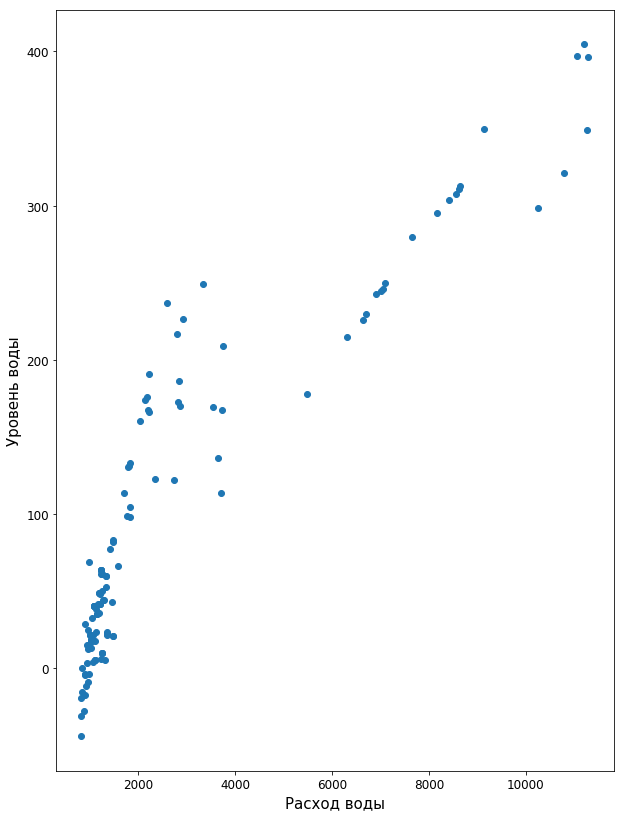

In [128]:
plt.scatter(np.ravel(np.array(dis_for)), np.ravel(np.array(calculated_levels)))
plt.ylabel('Уровень воды', fontsize=15)
plt.xlabel('Расход воды', fontsize=15)
plt.show()